In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import datetime
import mlccd_models
import os
import mlccd_diffusion
import pandas as pd

# deactivate GPU on ragnarok
# tf.config.set_visible_devices([], "GPU")

2025-02-27 10:21:39.199772: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-27 10:21:39.441595: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740680499.546873 1816845 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740680499.575900 1816845 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-27 10:21:39.823260: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

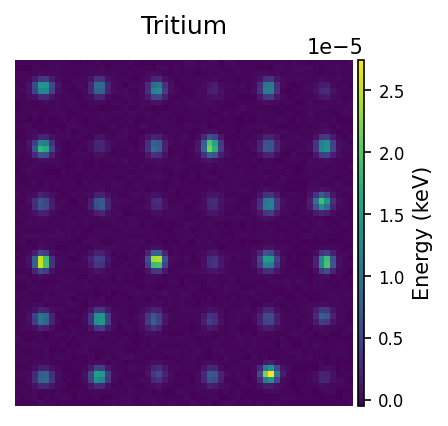

In [5]:
data_fermilab = mlccd_models.CCDData(
    os.path.expanduser('~/data/CCD_sim/2024-10-17-tritium-and-gamma-100keV-more-realistic-diffusion/tritium_10_17_add_classical_disc_add_BDT.h5'),
    image_unit="adc"
)
data_fermilab.plot(only_one_label=1, num_plots=36, title="Tritium")
# data_fermilab.plot(only_one_label=0, num_plots=36, title="Gamma")

# Clip the data between thresholds and normalize to 0-1
# data_fermilab.normalize(threshold_low=0, threshold_high=20)
# Divide the data into training, test, and validation sets
data_fermilab.divide_data(
    train_fraction=0.7, test_fraction=0.2, validation_fraction=0.1
)

In [17]:
data_fermilab.images.shape

(36079, 10, 10, 1)

In [3]:
# Load the training and test data
data_tritium = mlccd_models.CCDData(
    # os.path.expanduser("~/repos/mlccd_geant4_sim/Geant4_CCD_simulation/output/diffused_H3_5000000.h5"),
    os.path.expanduser("~/data/CCD_data/Simulated_training_clusters/2024-10-17-tritium-and-gamma-100keV-more-realistic-diffusion/tritium_10_17_add_classical_disc_add_BDT.h5"),
    # os.path.expanduser("~/data/CCD_data/Simulated_training_clusters/2024-10-26-tritium-and-gamma-evenly-distributed/diffused_H3_5000000.h5"),
    image_unit="keV"
)
data_gamma = mlccd_models.CCDData(
    # os.path.expanduser("~/repos/mlccd_geant4_sim/Geant4_CCD_simulation/output/diffused_gamma_20000000.h5"),
    os.path.expanduser("~/data/CCD_data/Simulated_training_clusters/2024-10-17-tritium-and-gamma-100keV-more-realistic-diffusion/gamma_10_17_add_classical_disc_add_BDT.h5"),
    # os.path.expanduser("~/data/CCD_data/Simulated_training_clusters/2024-10-26-tritium-and-gamma-evenly-distributed/diffused_gamma_20000000.h5"),
    image_unit="keV"
)
data_gamma.plot(title="Gamma", num_plots=36)
data_tritium.plot(title="Tritium", num_plots=36)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/home/emil/data/CCD_data/Simulated_training_clusters/2024-10-17-tritium-and-gamma-100keV-more-realistic-diffusion/tritium_10_17_add_classical_disc_add_BDT.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [5]:
# Combine the two datasets
ccd_data = 0.8 * data_gamma + 1 * data_tritium
# Clip the data between thresholds and normalize to 0-1
ccd_data.normalize(threshold_low=0, threshold_high=20)
# ccd_data = ccd_data.reduced(num_events=200000)
# Divide the data into training, test, and validation sets
ccd_data.divide_data(
    train_fraction=0.7, test_fraction=0.2, validation_fraction=0.1
)

In [6]:
os.path.expanduser("~/data/CCD_data/Simulated_training_clusters/2024-10-17-tritium-and-gamma-100keV-more-realistic-diffusion/both_incl_auto.h5")

'/home/emil/data/CCD_data/Simulated_training_clusters/2024-10-17-tritium-and-gamma-100keV-more-realistic-diffusion/both_incl_auto.h5'

In [6]:
ccd_data = mlccd_models.CCDData(os.path.expanduser("~/data/CCD_data/Simulated_training_clusters/2024-10-17-tritium-and-gamma-100keV-more-realistic-diffusion/both_incl_auto.h5"))
ccd_data.divide_data(
    train_fraction=0.7, test_fraction=0.2, validation_fraction=0.1
)

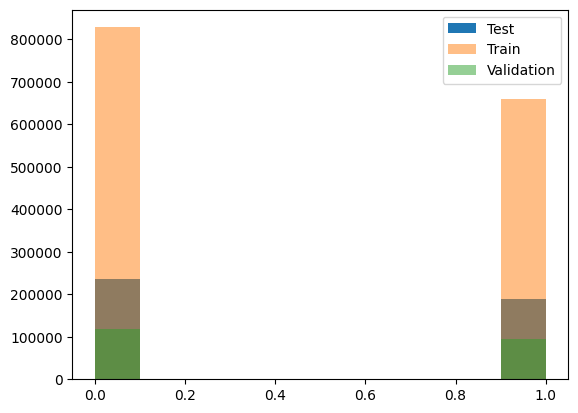

In [7]:
plt.hist(ccd_data.y_test, label="Test")
plt.hist(ccd_data.y_train, label="Train", alpha=0.5)
plt.hist(ccd_data.y_validation, label="Validation", alpha=0.5)
plt.legend()

In [8]:
gamma = 2
loss_function = tf.keras.losses.BinaryFocalCrossentropy(
    gamma=gamma, from_logits=False, apply_class_balancing=True
)
# loss_function = 'binary_crossentropy'
config = {
    "model_name": f'cnn_{datetime.datetime.now().strftime("%Y%m%d_%H%M")}',
    "learning_rate": 0.001,
    "architecture": "CNN",
    "dataset": ccd_data.file_path,
    "epochs": 25,
    "batch_size": 256 * 4,
    "loss_function": loss_function,
    "threshold_high": ccd_data.threshold_high,
    "threshold_low": ccd_data.threshold_low,
    "data_filename": ccd_data.file_path,
}

In [9]:
num_bkg = sum(ccd_data.labels == 0)
num_tritium = sum(ccd_data.labels == 1)
print(f"Number of background events: {num_bkg}")
print(f"Number of tritium events: {num_tritium}")


Number of background events: 1183224
Number of tritium events: 942191


In [10]:
# Create the model
model = mlccd_models.CNNModel(
    ccd_data.IMAGE_WIDTH,
    ccd_data.IMAGE_HEIGHT,
    ccd_data.IMAGE_CHANNELS,
)

adam_optimizer = tf.keras.optimizers.Adam(
    learning_rate=config["learning_rate"]
)

model.compile(optimizer=adam_optimizer, loss=config["loss_function"])

I0000 00:00:1730311630.452566   46258 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730311630.604409   46258 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730311630.604496   46258 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730311630.610869   46258 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730311630.610960   46258 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [16]:
mlccd_models.train(model=model, config=config, ccd_data=data_fermilab, offline=True)

Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 4.3940 - val_loss: 0.1113
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1249 - val_loss: 0.0453
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0489 - val_loss: 0.0378
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0372 - val_loss: 0.0349
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0348 - val_loss: 0.0334
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0333 - val_loss: 0.0320
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0320 - val_loss: 0.0314
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0312 - val_loss: 0.0306
Epoch 9/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0310 - val_loss: 0.0297
Epoch 10/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0290 - val_loss: 0.0289
Epoch 11/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0291 - val_loss: 0.0287
Epoch 12/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0280 - val_l

In [13]:
y_pred = model.predict(ccd_data.x_test)
classical_discriminator_scores = ccd_data.tracks_metadata.iloc[ccd_data.test_indices].classicalDiscriminatorS
discBDT_scores = ccd_data.tracks_metadata.iloc[ccd_data.test_indices].discBDT
autoencoder_scores = ccd_data.tracks_metadata.iloc[ccd_data.test_indices].prediction_autoencoder


13284/13284 ━━━━━━━━━━━━━━━━━━━━ 8s 634us/step


(<Figure size 600x450 with 1 Axes>,
 <Axes: title={'center': 'Receiver Operating Characteristic'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

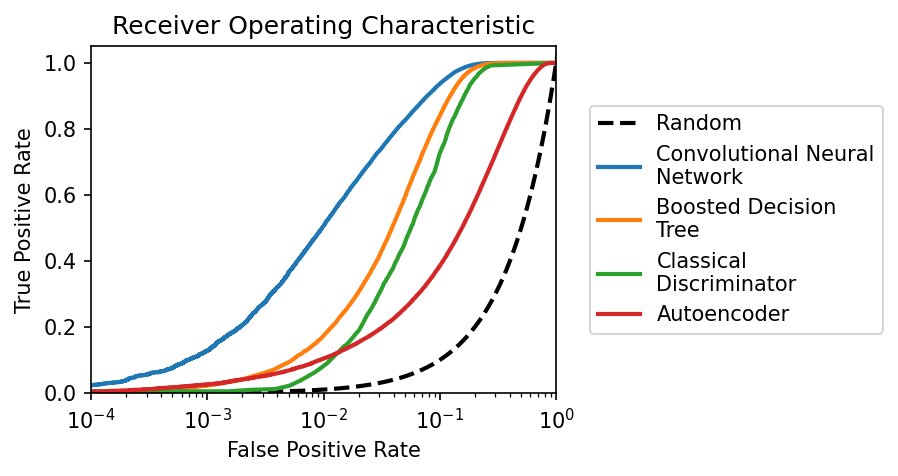

In [14]:
fig, ax = mlccd_models.plot_roc_curve(ccd_data.y_test, y_pred, log_scale=True, label="Convolutional Neural\nNetwork")
mlccd_models.plot_roc_curve(ccd_data.y_test, discBDT_scores, ax=ax, log_scale=True, label="Boosted Decision\nTree")
mlccd_models.plot_roc_curve(ccd_data.y_test, classical_discriminator_scores, ax=ax, log_scale=True, label="Classical\nDiscriminator")
mlccd_models.plot_roc_curve(ccd_data.y_test, autoencoder_scores, ax=ax, log_scale=True, label="Autoencoder")


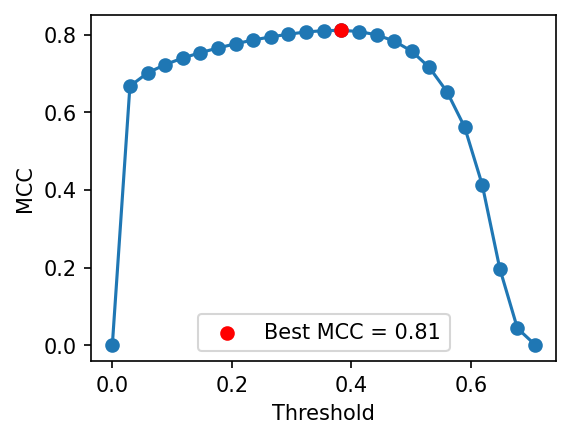

In [76]:
max_mcc, mcc_threshold = (
    mlccd_models.scan_mcc(
        ccd_data.y_test, y_pred, plot=True
    )
)

In [77]:
min_mda_classical, mda_threshold_classical = mlccd_models.scan_mda(ccd_data.y_test, classical_discriminator_scores, plot=True)

NameError: name 'classical_discriminator_scores' is not defined

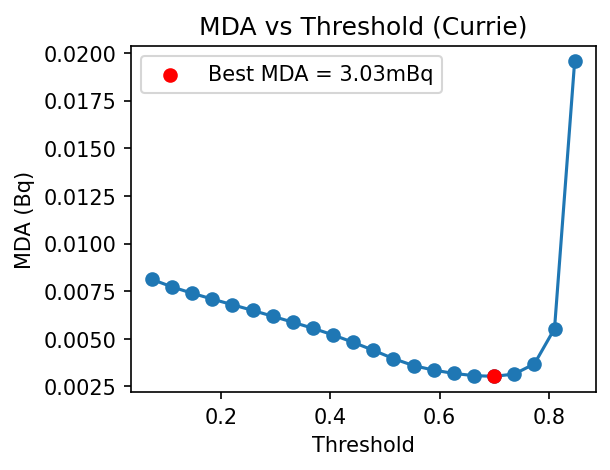

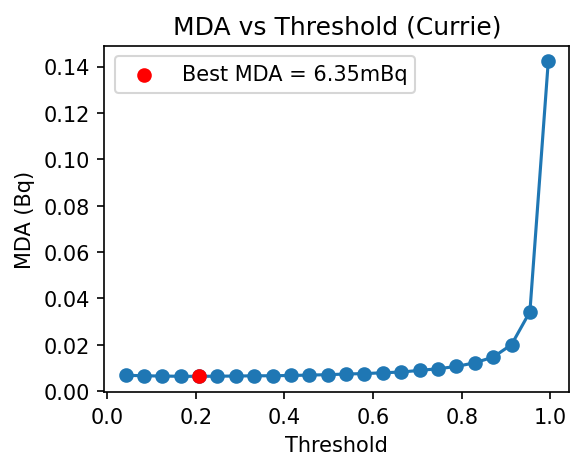

In [141]:
min_mda, mda_threshold = mlccd_models.scan_mda(ccd_data.y_test, y_pred, plot=True)
min_mda, mda_threshold = mlccd_models.scan_mda(ccd_data.y_test, classical_discriminator_scores, plot=True)


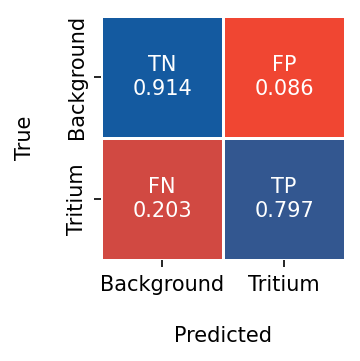

In [79]:

_ = mlccd_models.plot_confusion_matrix(
    ccd_data.y_test, y_pred, threshold=mda_threshold
)

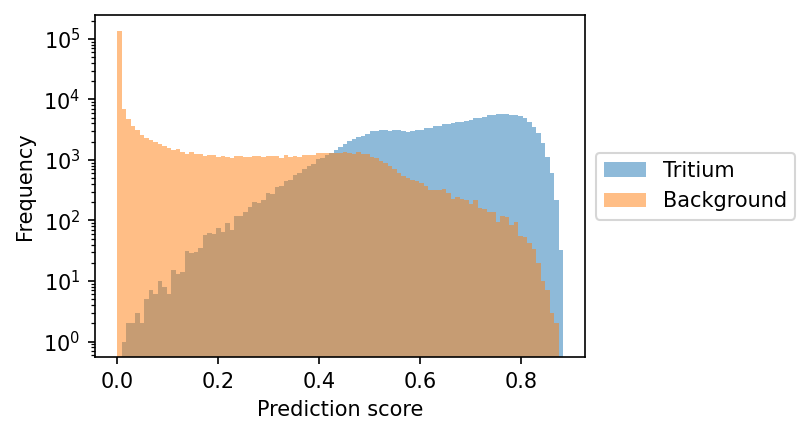

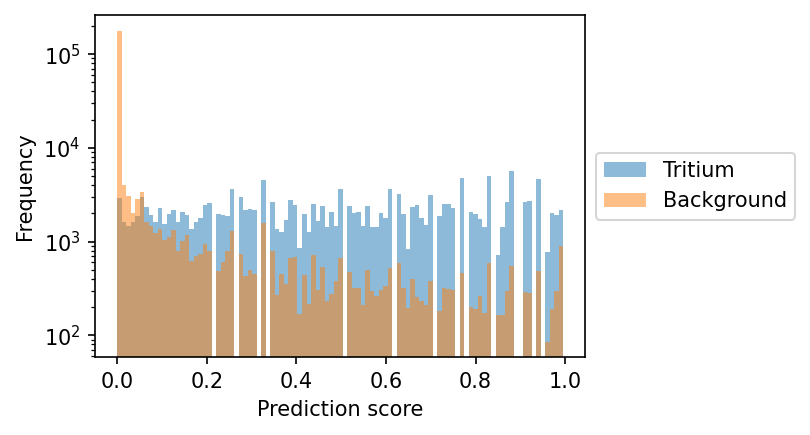

In [140]:
fig, ax  = mlccd_models.plot_scores(ccd_data.y_test, y_pred, threshold_mcc_optimal=None, threshold_mda_optimal=None)
fig, ax  = mlccd_models.plot_scores(ccd_data.y_test, classical_discriminator_scores)

## Look at clusters of FP, TN, TP, FN

13284/13284 ━━━━━━━━━━━━━━━━━━━━ 8s 584us/step


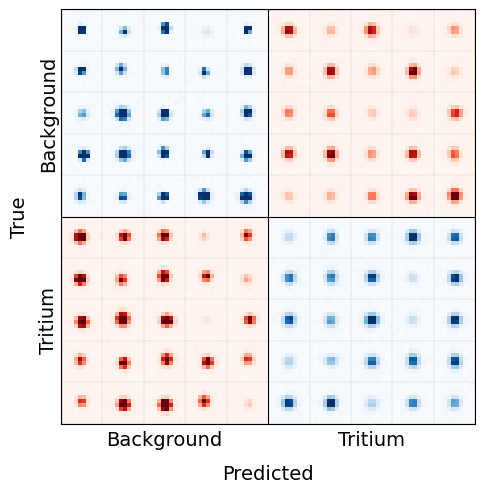

In [45]:
y_pred = model.predict(ccd_data.x_test)
_ = mlccd_models.plot_prediction_grid(ccd_data, y_pred, low_threshold=0.3, high_threshold=0.6, vmin=0, vmax=0.07)

# Find extremes

In [46]:
predictions = model.predict(ccd_data.x_test).flatten()
high_threshold = 0.6
low_threshold = 0.2
high_threshold = mda_threshold
low_threshold = mda_threshold
print(f"High threshold: {high_threshold}")
print(f"Low threshold: {low_threshold}")
# Categorize predictions
predictions_categorical = np.zeros_like(predictions, dtype=int)
predictions_categorical[predictions > high_threshold] = 1
predictions_categorical[(predictions >= low_threshold) & (predictions <= high_threshold)] = 2

true_negatives = np.where((predictions_categorical == 0) & (ccd_data.y_test == 0))[0]
false_positives = np.where((predictions_categorical == 1) & (ccd_data.y_test == 0))[0]
false_negatives = np.where((predictions_categorical == 0) & (ccd_data.y_test == 1))[0]
true_positives = np.where((predictions_categorical == 1) & (ccd_data.y_test == 1))[0]
uncertain = np.where(predictions_categorical == 2)[0]
FN_primaryIDs = ccd_data.tracks_metadata.iloc[false_negatives].primaryID.values
TP_primaryIDs = ccd_data.tracks_metadata.iloc[true_positives].primaryID.values
FP_primaryIDs = ccd_data.tracks_metadata.iloc[false_positives].primaryID.values
TN_primaryIDs = ccd_data.tracks_metadata.iloc[true_negatives].primaryID.values

13284/13284 ━━━━━━━━━━━━━━━━━━━━ 8s 581us/step


NameError: name 'mda_threshold' is not defined

In [96]:
ccd_data.tracks_metadata

index  primaryID  subCluster  energyActiveCCDSumKeV     xFirstUm  \
0        17994   64035306           1               3.423144   260.479944   
1           32   13987134           1               5.188469   -84.125920   
2        13417   63763482           2               7.502254 -2690.950012   
3        13509   19485183           1              15.263598 -4031.433075   
4        15192   46370310           1              14.731375   -85.536278   
...        ...        ...         ...                    ...          ...   
1907871   1840     926961           1              14.625880     2.301223   
1907872  12647    2652112           1               2.553689    -3.700667   
1907873  14929    3579106           1               0.730557     2.610470   
1907874    744    4669915           1               1.289757     2.083913   
1907875   8723    4879176           1               6.159793     2.157909   

            yFirstUm    zFirstUm  primaryKind  energyPrimaryKeV  \
0        -952.468776  229.288315           22        100.000000   
1        -154.349334   15.844438           22        100.000000   
2       -2373.058918  546.169250           22        100.000000   
3       -3803.531922  317.724640           22        100.000000   
4         103.453285    3.385352           22        100.000000   
...              ...         ...          ...               ...   
1907871    -0.669630    0.139176   1000010030         15.206232   
1907872    -5.858020    0.101881   1000010030          5.838221   
1907873    -1.386860    0.100055   1000010030          3.505060   
1907874     1.813759    0.105283   1000010030         13.466764   
1907875     1.170963    0.120145   1000010030          8.212653   

        stepKindsUnique  creatorProcessesUnique  \
0              b'22,11'  b'primary,compt,eIoni'   
1              b'22,11'  b'primary,compt,eIoni'   
2              b'22,11'  b'primary,compt,eIoni'   
3              b'22,11'  b'primary,compt,eIoni'   
4              b'22,11'  b'primary,compt,eIoni'   
...                 ...                     ...   
1907871           b'11'     b'Radioactiv,eIoni'   
1907872           b'11'     b'Radioactiv,eIoni'   
1907873           b'11'     b'Radioactiv,eIoni'   
1907874           b'11'     b'Radioactiv,eIoni'   
1907875           b'11'     b'Radioactiv,eIoni'   

         numParticlesIncludingSecondaries  energyEscapeSumKeV  \
0                                       8           96.576859   
1                                      13           94.811531   
2                                      10           85.777130   
3                                      13           84.736404   
4                                      39           85.268623   
...                                   ...                 ...   
1907871                                23            0.000000   
1907872                                 6            0.000000   
1907873                                 2            0.000000   
1907874                                 3           16.281925   
1907875                                15           10.376618   

         energyDeadLayerSumKeV  
0                     0.000000  
1                     0.000000  
2                     0.000000  
3                     0.000000  
4                     0.000000  
...                        ...  
1907871               0.580352  
1907872               3.284532  
1907873               2.774503  
1907874               1.016892  
1907875               2.052861  

[1907876 rows x 14 columns]

<Axes: ylabel='Frequency'>

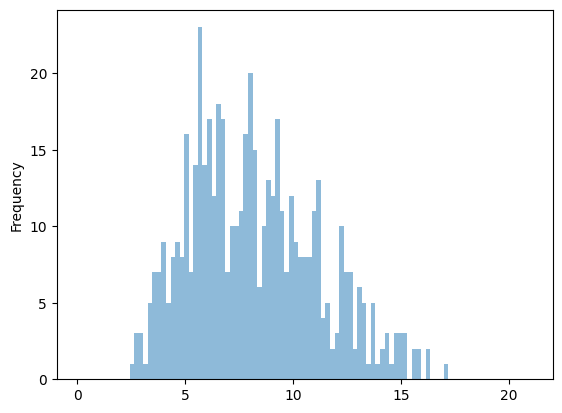

In [98]:
ccd_data.tracks_metadata.query('primaryID in @FN_primaryIDs & primaryKind != 22').energyPrimaryKeV.plot(kind='hist', bins=bins, label="False negatives", alpha=0.5)


Text(0, 0.5, 'Counts')

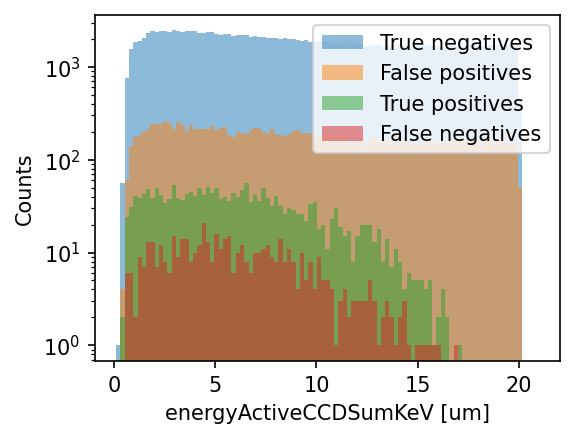

In [101]:
bins = np.linspace(0.1, 21, 100)
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
ccd_data.tracks_metadata.query('primaryID in @TN_primaryIDs & primaryKind == 22').energyActiveCCDSumKeV.plot(kind='hist', bins=bins, label="True negatives", alpha=0.5, ax=ax)
ccd_data.tracks_metadata.query('primaryID in @FP_primaryIDs & primaryKind == 22').energyActiveCCDSumKeV.plot(kind='hist', bins=bins, label="False positives", alpha=0.5, ax=ax)
ccd_data.tracks_metadata.query('primaryID in @TP_primaryIDs & primaryKind != 22').energyActiveCCDSumKeV.plot(kind='hist', bins=bins, label="True positives", alpha=0.5, ax=ax)
ccd_data.tracks_metadata.query('primaryID in @FN_primaryIDs & primaryKind != 22').energyActiveCCDSumKeV.plot(kind='hist', bins=bins, label="False negatives", alpha=0.5, ax=ax)
plt.yscale('log')
plt.legend()
plt.xlabel("energyActiveCCDSumKeV [um]")
plt.ylabel("Counts")

Text(0, 0.5, 'Counts')

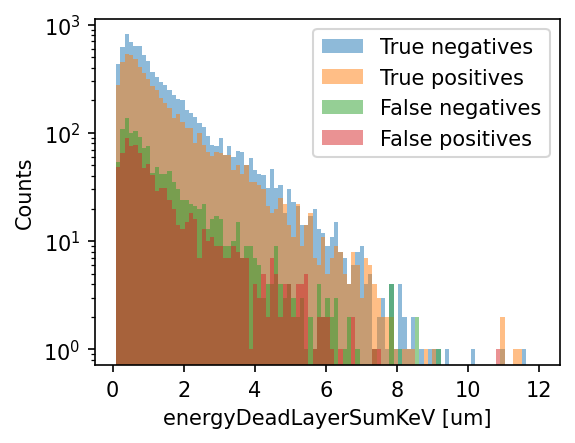

In [27]:
bins = np.linspace(0.1, 12, 100)
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
ccd_data.tracks_metadata.query('primaryID in @TN_primaryIDs').energyDeadLayerSumKeV.plot(kind='hist', bins=bins, label="True negatives", alpha=0.5, ax=ax)
ccd_data.tracks_metadata.query('primaryID in @TP_primaryIDs').energyDeadLayerSumKeV.plot(kind='hist', bins=bins, label="True positives", alpha=0.5, ax=ax)
ccd_data.tracks_metadata.query('primaryID in @FN_primaryIDs').energyDeadLayerSumKeV.plot(kind='hist', bins=bins, label="False negatives", alpha=0.5, ax=ax)
ccd_data.tracks_metadata.query('primaryID in @FP_primaryIDs').energyDeadLayerSumKeV.plot(kind='hist', bins=bins, label="False positives", alpha=0.5, ax=ax)
plt.yscale('log')
plt.legend()
plt.xlabel("energyDeadLayerSumKeV [um]")
plt.ylabel("Counts")

UndefinedVariableError: local variable 'TN_primaryIDs' is not defined

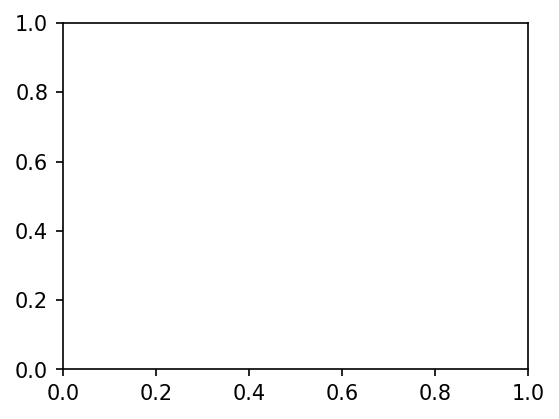

In [47]:
bins = np.linspace(0.1, 0.2, 100)
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
ccd_data.tracks_metadata.query('primaryID in @TN_primaryIDs').zFirstUm.plot(kind='hist', bins=bins, label="True negatives", alpha=0.5, ax=ax)
ccd_data.tracks_metadata.query('primaryID in @TP_primaryIDs').zFirstUm.plot(kind='hist', bins=bins, label="True positives", alpha=0.5, ax=ax)
ccd_data.tracks_metadata.query('primaryID in @FN_primaryIDs').zFirstUm.plot(kind='hist', bins=bins, label="False negatives", alpha=0.5, ax=ax)
ccd_data.tracks_metadata.query('primaryID in @FP_primaryIDs').zFirstUm.plot(kind='hist', bins=bins, label="False positives", alpha=0.5, ax=ax)
plt.yscale('log')
plt.legend()
plt.xlabel("zFirstUm [um]")
plt.ylabel("Counts")


bins = np.linspace(0, 25, 25)
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
ccd_data.tracks_metadata.query('primaryID in @TN_primaryIDs').clusterNpix.plot(kind='hist', bins=bins, label="True negatives", alpha=0.5, ax=ax)
ccd_data.tracks_metadata.query('primaryID in @TP_primaryIDs').clusterNpix.plot(kind='hist', bins=bins, label="True positives", alpha=0.5, ax=ax)
ccd_data.tracks_metadata.query('primaryID in @FN_primaryIDs').clusterNpix.plot(kind='hist', bins=bins, label="False negatives", alpha=0.5, ax=ax)
ccd_data.tracks_metadata.query('primaryID in @FP_primaryIDs').clusterNpix.plot(kind='hist', bins=bins, label="False positives", alpha=0.5, ax=ax)
plt.yscale('log')
plt.legend()
plt.xlabel("clusterNpix [um]")
plt.ylabel("Counts")

UndefinedVariableError: local variable 'TN_primaryIDs' is not defined

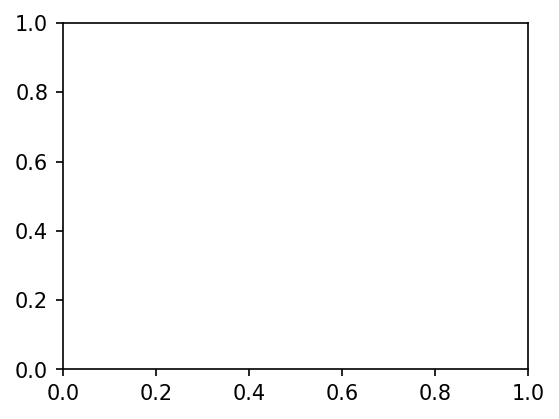

In [48]:
bins = np.linspace(0.1, 1.2, 100)
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
sigma_x_min_TN = np.min((ccd_data.tracks_metadata.query('primaryID in @TN_primaryIDs').clusterSigmaX.values, ccd_data.tracks_metadata.query('primaryID in @TN_primaryIDs').clusterSigmaY.values), axis=0)
sigma_x_min_TP = np.min((ccd_data.tracks_metadata.query('primaryID in @TP_primaryIDs').clusterSigmaX.values, ccd_data.tracks_metadata.query('primaryID in @TP_primaryIDs').clusterSigmaY.values), axis=0)
sigma_x_min_FN = np.min((ccd_data.tracks_metadata.query('primaryID in @FN_primaryIDs').clusterSigmaX.values, ccd_data.tracks_metadata.query('primaryID in @FN_primaryIDs').clusterSigmaY.values), axis=0)
sigma_x_min_FP = np.min((ccd_data.tracks_metadata.query('primaryID in @FP_primaryIDs').clusterSigmaX.values, ccd_data.tracks_metadata.query('primaryID in @FP_primaryIDs').clusterSigmaY.values), axis=0)
ax.hist(sigma_x_min_TN, bins=bins, label="True negatives", alpha=0.5)
ax.hist(sigma_x_min_TP, bins=bins, label="True positives", alpha=0.5)
ax.hist(sigma_x_min_FN, bins=bins, label="False negatives", alpha=0.5)
ax.hist(sigma_x_min_FP, bins=bins, label="False positives", alpha=0.5)
plt.yscale('log')
plt.legend()
plt.xlabel("min(sigma_x, sigma_y) [um]")
plt.ylabel("Counts")

bins = np.linspace(0.1, 1.2, 100)
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
sigma_x_max_TN = np.max((ccd_data.tracks_metadata.query('primaryID in @TN_primaryIDs').clusterSigmaX.values, ccd_data.tracks_metadata.query('primaryID in @TN_primaryIDs').clusterSigmaY.values), axis=0)
sigma_x_max_TP = np.max((ccd_data.tracks_metadata.query('primaryID in @TP_primaryIDs').clusterSigmaX.values, ccd_data.tracks_metadata.query('primaryID in @TP_primaryIDs').clusterSigmaY.values), axis=0)
sigma_x_max_FN = np.max((ccd_data.tracks_metadata.query('primaryID in @FN_primaryIDs').clusterSigmaX.values, ccd_data.tracks_metadata.query('primaryID in @FN_primaryIDs').clusterSigmaY.values), axis=0)
sigma_x_max_FP = np.max((ccd_data.tracks_metadata.query('primaryID in @FP_primaryIDs').clusterSigmaX.values, ccd_data.tracks_metadata.query('primaryID in @FP_primaryIDs').clusterSigmaY.values), axis=0)
ax.hist(sigma_x_max_TN, bins=bins, label="True negatives", alpha=0.5)
ax.hist(sigma_x_max_TP, bins=bins, label="True positives", alpha=0.5)
ax.hist(sigma_x_max_FN, bins=bins, label="False negatives", alpha=0.5)
ax.hist(sigma_x_max_FP, bins=bins, label="False positives", alpha=0.5)
plt.yscale('log')
plt.legend()
plt.xlabel("max(sigma_x, sigma_y) [um]")
plt.ylabel("Counts")


In [62]:
predictions_all = model.predict(ccd_data.images)
ccd_data.tracks_metadata['prediction_cnn'] = predictions_all.flatten()

66420/66420 ━━━━━━━━━━━━━━━━━━━━ 41s 611us/step


Text(0, 0.5, 'Prediction score')

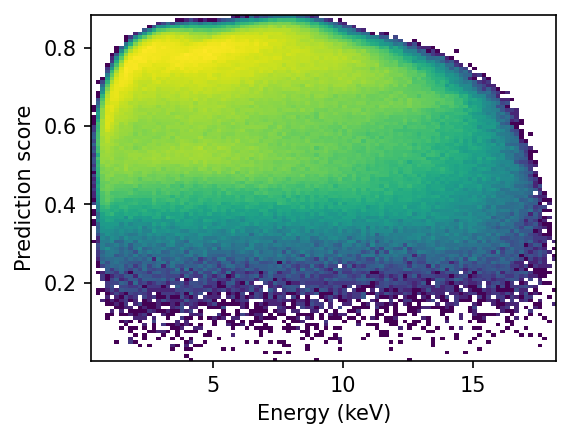

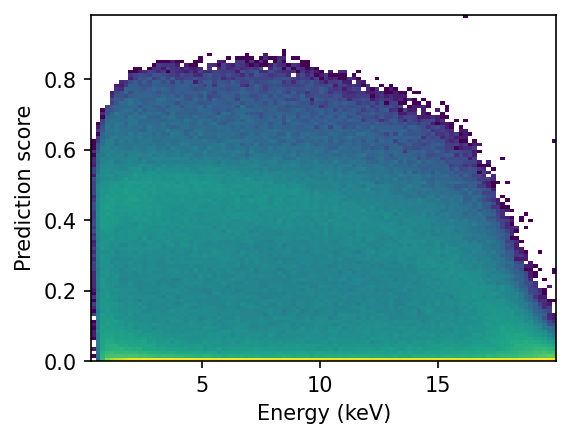

In [63]:
from matplotlib.colors import LogNorm

energy = ccd_data.tracks_metadata.query('primaryKind != 22').energyActiveCCDSumKeV.values
scores = ccd_data.tracks_metadata.query('primaryKind != 22').prediction_cnn.values
fig, ax = plt.subplots(figsize=(4,3), dpi=150)
_ = ax.hist2d(energy, scores, bins=100, norm=LogNorm())
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('Prediction score')

energy = ccd_data.tracks_metadata.query('primaryKind == 22').energyActiveCCDSumKeV.values
scores = ccd_data.tracks_metadata.query('primaryKind == 22').prediction_cnn.values
fig, ax = plt.subplots(figsize=(4,3), dpi=150)
_ = ax.hist2d(energy, scores, bins=100, norm=LogNorm())
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('Prediction score')
# plt.colorbar()

In [60]:
ccd_data.tracks_metadata

index  primaryID  tritiumID  energyActiveCCDSumKeV     xFirstUm  \
0         4849   15431795        0.0               9.516604  2467.245361   
1        14657   24206671        0.0               4.292255   -34.778385   
2        11802   47359982        0.0              11.546801    41.030590   
3         7729   16803844        0.0              15.728180 -2105.590576   
4         7173   37740197        0.0               2.040323 -2683.333740   
...        ...        ...        ...                    ...          ...   
2125410   9513    4966822        1.0               1.392501    -0.417280   
2125411   8457    1962959        1.0               3.117830    -0.140424   
2125412    320     335675        1.0               8.272268     0.189151   
2125413    995    2339976        1.0               7.307796     2.374843   
2125414   3282     601457        1.0              10.967611    -0.227440   

            yFirstUm    zFirstUm  primaryKind  energyPrimaryKeV  \
0         121.984764  471.058472           22        100.000000   
1         -54.268394    4.794209           22        100.000000   
2          51.916904  218.557068           22        100.000000   
3          33.200459  555.994080           22        100.000000   
4       -4055.164551  236.927582           22        100.000000   
...              ...         ...          ...               ...   
2125410    -0.868456    0.103771   1000010030          5.177880   
2125411    -0.265505    0.101568   1000010030          4.001467   
2125412     0.026310    0.101243   1000010030         12.015442   
2125413    -1.045625    0.114704   1000010030          8.686865   
2125414    -2.146697    0.130477   1000010030         11.258462   

        stepKindsUnique  ... clusterMinSigma  clusterMaxSigma  clusterNpix  \
0              b'22,11'  ...        0.394836         0.453576            6   
1              b'22,11'  ...        0.781457         0.853736           14   
2              b'22,11'  ...        0.696891         0.729686           15   
3              b'22,11'  ...        0.310538         0.359670            5   
4              b'22,11'  ...        0.463390         0.611797            7   
...                 ...  ...             ...              ...          ...   
2125410           b'11'  ...        0.736291         0.742436            9   
2125411           b'11'  ...        0.758598         0.788536           12   
2125412           b'11'  ...        0.809719         0.840456           16   
2125413           b'11'  ...        0.791265         0.833497           15   
2125414           b'11'  ...        0.867536         0.903533           20   

         clusterWidthX  clusterWidthY  classicalDiscriminatorS   discBDT  \
0                    3              3                 0.000000  0.010139   
1                    5              5                 0.594845  0.828453   
2                    4              4                 0.000000  0.014721   
3                    3              2                 0.000000  0.010139   
4                    3              3                 0.000000  0.028214   
...                ...            ...                      ...       ...   
2125410              4              4                 0.242532  0.856559   
2125411              4              4                 0.468337  0.744129   
2125412              4              4                 0.526760  0.842364   
2125413              4              4                 0.426911  0.768420   
2125414              6              5                 0.222119  0.844032   

         energyResidual  prediction_autoencoder  prediction_cnn  
0                   NaN            7.540177e+08    5.413322e-28  
1                   NaN            4.847101e+09    4.049015e-01  
2                   NaN            1.827271e+10    7.030042e-03  
3                   NaN            2.957631e-06    0.000000e+00  
4                   NaN            1.457512e+10    7.166311e-05  
...                 ...                     .

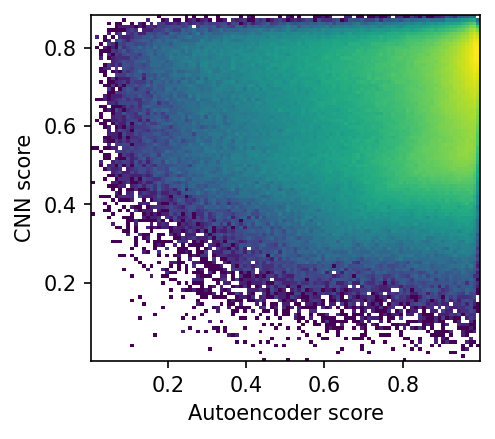

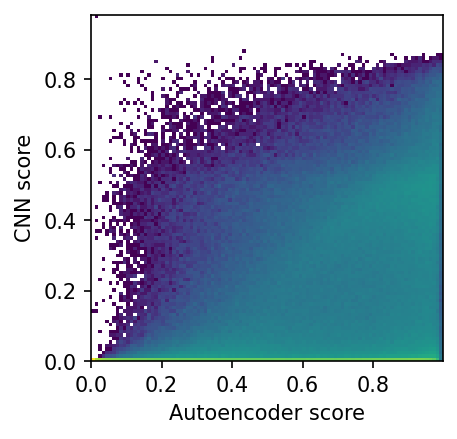

In [64]:
auto = ccd_data.tracks_metadata.query('primaryKind != 22').prediction_autoencoder.values
cnn = ccd_data.tracks_metadata.query('primaryKind != 22').prediction_cnn.values
fig, ax = plt.subplots(figsize=(4,3), dpi=150)
_ = ax.hist2d(auto, cnn, bins=100, norm=LogNorm())
ax.set_xlabel('Autoencoder score')
ax.set_ylabel('CNN score')
ax.set_aspect('equal')
auto = ccd_data.tracks_metadata.query('primaryKind == 22').prediction_autoencoder.values
cnn = ccd_data.tracks_metadata.query('primaryKind == 22').prediction_cnn.values
fig, ax = plt.subplots(figsize=(4,3), dpi=150)
_ = ax.hist2d(auto, cnn, bins=100, norm=LogNorm())
ax.set_xlabel('Autoencoder score')
ax.set_ylabel('CNN score')
ax.set_aspect('equal')

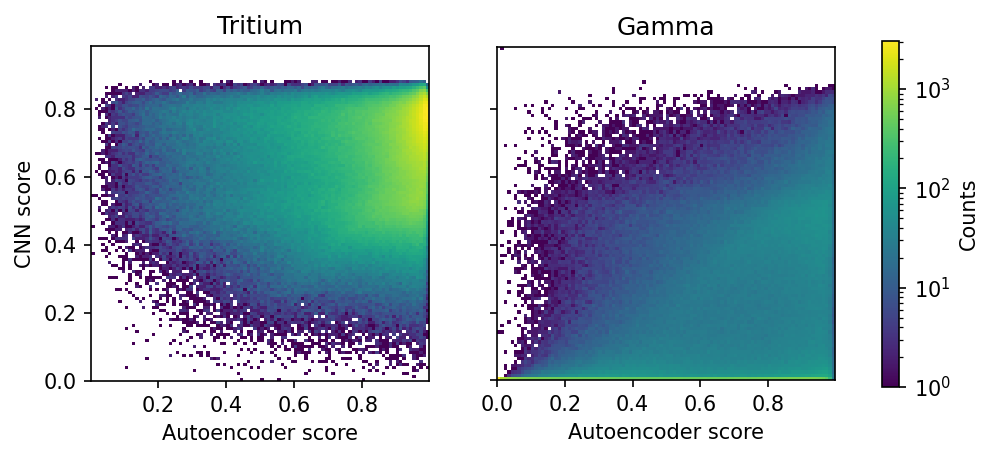

In [68]:
# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3), dpi=150, sharey=True)

# Plot tritium (primaryKind != 22)
auto_tritium = ccd_data.tracks_metadata.query('primaryKind != 22').prediction_autoencoder.values
cnn_tritium = ccd_data.tracks_metadata.query('primaryKind != 22').prediction_cnn.values
hist1 = ax1.hist2d(auto_tritium, cnn_tritium, bins=100, norm=LogNorm())
ax1.set_xlabel('Autoencoder score')
ax1.set_ylabel('CNN score')
ax1.set_aspect('equal')
ax1.set_title('Tritium')

# Plot gamma (primaryKind == 22)
auto_gamma = ccd_data.tracks_metadata.query('primaryKind == 22').prediction_autoencoder.values
cnn_gamma = ccd_data.tracks_metadata.query('primaryKind == 22').prediction_cnn.values
hist2 = ax2.hist2d(auto_gamma, cnn_gamma, bins=100, norm=LogNorm())
ax2.set_xlabel('Autoencoder score')
ax2.set_aspect('equal')
ax2.set_title('Gamma')

# Add colorbar
fig.colorbar(hist1[3], ax=(ax1, ax2), label='Counts')

# Adjust layout to prevent overlap
# plt.tight_layout()

In [24]:
import seaborn as sns


def plot_2d_histogram(column_name, xlim=None, ylim=None):
    # Prepare data for 2D histograms
    min_sigma = np.minimum(
        ccd_data.tracks_metadata.clusterSigmaX,
        ccd_data.tracks_metadata.clusterSigmaY
    )

    # Create a DataFrame for plotting
    plot_data = pd.DataFrame({
        'min_sigma': min_sigma,
        'column_name': ccd_data.tracks_metadata[column_name],
        'label': np.select(
            [
                ccd_data.tracks_metadata.primaryID.isin(TP_primaryIDs),  # True Positives
                ccd_data.tracks_metadata.primaryID.isin(TN_primaryIDs),  # True Negatives
                ccd_data.tracks_metadata.primaryID.isin(FP_primaryIDs),  # False Positives
                ccd_data.tracks_metadata.primaryID.isin(FN_primaryIDs)   # False Negatives
            ],
            ['TP', 'TN', 'FP', 'FN'],
            default='Unknown'
        )
    })

    # Define categories
    categories = ['TP', 'TN', 'FP', 'FN']

    # Create 2D contour heatmaps for each category
    fig, axes = plt.subplots(2, 2, figsize=(7, 6))

    for i, category in enumerate(categories):
        ax = axes[i // 2, i % 2]
        
        # Filter data for the current category
        category_data = plot_data[plot_data['label'] == category]
        
        # Create a 2D histogram with contour
        bins_x = np.linspace(0, 3, 50) if xlim is None else np.linspace(xlim[0], xlim[1], 50)
        bins_y = np.linspace(0.1, 2, 50) if ylim is None else np.linspace(ylim[0], ylim[1], 50)
        bins = [bins_x, bins_y]
        sns.histplot(data=category_data, x='column_name', y='min_sigma', 
                    bins=bins, ax=ax, cmap='viridis', pthresh=0.05, 
                    cbar=True, stat='count', fill=True)
        
        ax.set_title(f'{category} Histogram')
        ax.set_xlabel(column_name)
        ax.set_ylabel('Min(Sigma_x, Sigma_y) [um]')
        # ax.set_yscale('log')  # Optional: log scale for better visibility
    plt.suptitle(column_name)
    plt.tight_layout()
    plt.show()
plot_2d_histogram('energyDeadLayerSumKeV', xlim=(0, 15))
plot_2d_histogram('zFirstUm', xlim=(0, 0.25))
plot_2d_histogram('clusterNpix', xlim=(0, 25))
# Read ROOT to plot trajectories

AttributeError: 'DataFrame' object has no attribute 'clusterSigmaX'

# Add predictions to metadata

In [104]:
predictions_all = model.predict(ccd_data.images)
ccd_data.tracks_metadata['prediction'] = predictions_all.flatten()

59622/59622 ━━━━━━━━━━━━━━━━━━━━ 42s 706us/step


In [105]:
ccd_data.tracks_metadata

index  primaryID  subCluster  energyActiveCCDSumKeV     xFirstUm  \
0        17994   64035306           1               3.423144   260.479944   
1           32   13987134           1               5.188469   -84.125920   
2        13417   63763482           2               7.502254 -2690.950012   
3        13509   19485183           1              15.263598 -4031.433075   
4        15192   46370310           1              14.731375   -85.536278   
...        ...        ...         ...                    ...          ...   
1907871   1840     926961           1              14.625880     2.301223   
1907872  12647    2652112           1               2.553689    -3.700667   
1907873  14929    3579106           1               0.730557     2.610470   
1907874    744    4669915           1               1.289757     2.083913   
1907875   8723    4879176           1               6.159793     2.157909   

            yFirstUm    zFirstUm  primaryKind  energyPrimaryKeV  \
0        -952.468776  229.288315           22        100.000000   
1        -154.349334   15.844438           22        100.000000   
2       -2373.058918  546.169250           22        100.000000   
3       -3803.531922  317.724640           22        100.000000   
4         103.453285    3.385352           22        100.000000   
...              ...         ...          ...               ...   
1907871    -0.669630    0.139176   1000010030         15.206232   
1907872    -5.858020    0.101881   1000010030          5.838221   
1907873    -1.386860    0.100055   1000010030          3.505060   
1907874     1.813759    0.105283   1000010030         13.466764   
1907875     1.170963    0.120145   1000010030          8.212653   

        stepKindsUnique  creatorProcessesUnique  \
0              b'22,11'  b'primary,compt,eIoni'   
1              b'22,11'  b'primary,compt,eIoni'   
2              b'22,11'  b'primary,compt,eIoni'   
3              b'22,11'  b'primary,compt,eIoni'   
4              b'22,11'  b'primary,compt,eIoni'   
...                 ...                     ...   
1907871           b'11'     b'Radioactiv,eIoni'   
1907872           b'11'     b'Radioactiv,eIoni'   
1907873           b'11'     b'Radioactiv,eIoni'   
1907874           b'11'     b'Radioactiv,eIoni'   
1907875           b'11'     b'Radioactiv,eIoni'   

         numParticlesIncludingSecondaries  energyEscapeSumKeV  \
0                                       8           96.576859   
1                                      13           94.811531   
2                                      10           85.777130   
3                                      13           84.736404   
4                                      39           85.268623   
...                                   ...                 ...   
1907871                                23            0.000000   
1907872                                 6            0.000000   
1907873                                 2            0.000000   
1907874                                 3           16.281925   
1907875                                15           10.376618   

         energyDeadLayerSumKeV    prediction  
0                     0.000000  4.747564e-04  
1                     0.000000  5.035225e-01  
2                     0.000000  6.767694e-20  
3                     0.000000  3.522137e-22  
4                     0.000000  5.320395e-01  
...                        ...           ...  
1907871               0.580352  4.147510e-01  
1907872               3.284532  6.665834e-01  
1907873               2.774503  5.879583e-01  
1907874               1.016892  6.031410e-01  
1907875               2.052861  5.633703e-01  

[1907876 rows x 15 columns]

Text(0, 0.5, 'Prediction score')

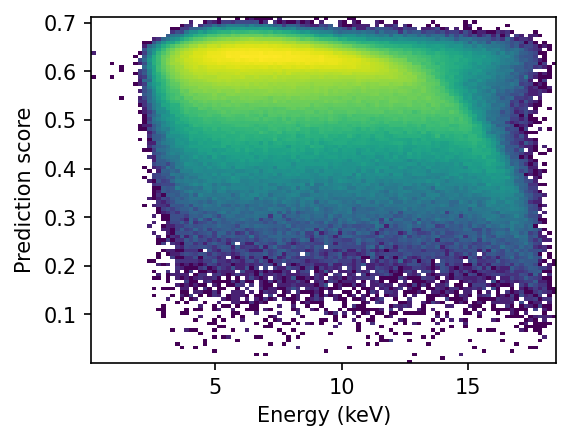

In [119]:
from matplotlib.colors import LogNorm

energy = ccd_data.tracks_metadata.query('primaryKind != 22').energyPrimaryKeV.values
scores = ccd_data.tracks_metadata.query('primaryKind != 22').prediction.values
fig, ax = plt.subplots(figsize=(4,3), dpi=150)
fig, ax = plt.subplots(figsize=(4,3), dpi=150)
_ = ax.hist2d(energy, scores, bins=100, norm=LogNorm())
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('Prediction score')
# plt.colorbar()

Text(0, 0.5, 'Prediction score')

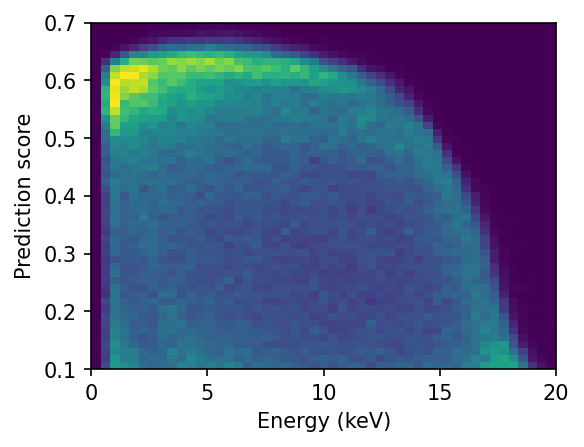

In [126]:
from matplotlib.colors import LogNorm

energy = ccd_data.tracks_metadata.query('primaryKind == 22').energyActiveCCDSumKeV.values
scores = ccd_data.tracks_metadata.query('primaryKind == 22').prediction.values
fig, ax = plt.subplots(figsize=(4,3), dpi=150)
xbins = np.linspace(0,20,50)
ybins = np.linspace(0.1,0.7,50)
bins = [xbins, ybins]
_ = ax.hist2d(energy, scores, bins=bins)#, norm=LogNorm())
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('Prediction score')
# plt.colorbar()

In [39]:
def assign_fp(df):
    if df.primaryKind == 1000010030 and df.prediction > mda_threshold:
        return 'TP'
    elif df.primaryKind == 1000010030 and df.prediction < mda_threshold:
        return 'FN'
    elif df.primaryKind == 22 and df.prediction < mda_threshold:
        return 'TN'
    elif df.primaryKind == 22 and df.prediction > mda_threshold:
        return 'FP'
ccd_data.tracks_metadata.apply()

0.5240417867898941

In [38]:
ccd_data.tracks_metadata

index  primaryID  subCluster  energyActiveCCDSumKeV    xFirstUm  \
0       15809    4748471           1               9.765144    3.616206   
1        7593    1875794           1               6.053021   -1.810500   
2        7733    2876484           1              13.175357    1.340037   
3       17216   13828455           1               2.177399 -148.040906   
4        9106    1800745           1               7.370904   -2.134867   
...       ...        ...         ...                    ...         ...   
199995   3225     183377           1               3.244755   -0.925090   
199996   2187    3678464           1               8.770719    1.559907   
199997  13129    1987965           1               1.169378   -3.020270   
199998   1053   68885646           1               7.308804   16.062727   
199999  12393    4170094           2               3.702220  -94.534508   

          yFirstUm   zFirstUm  primaryKind  energyPrimaryKeV stepKindsUnique  \
0         1.927649   0.120931   1000010030          9.870899           b'11'   
1         2.912009   0.100679   1000010030          6.939226           b'11'   
2        -1.122809   0.112609   1000010030         14.093740           b'11'   
3      -918.223108  24.959131           22        100.000000        b'22,11'   
4         1.302657   0.104684   1000010030          7.708360           b'11'   
...            ...        ...          ...               ...             ...   
199995    2.808186   0.102040   1000010030         12.870240           b'11'   
199996    0.668065   0.105493   1000010030          8.934026           b'11'   
199997    1.366786   0.107037   1000010030          4.806326           b'11'   
199998    4.088933  22.412300           22        100.000000        b'22,11'   
199999    3.049801  31.099035           22        100.000000        b'22,11'   

        creatorProcessesUnique  numParticlesIncludingSecondaries  \
0          b'Radioactiv,eIoni'                                20   
1          b'Radioactiv,eIoni'                                16   
2          b'Radioactiv,eIoni'                                24   
3       b'primary,compt,eIoni'                                 4   
4          b'Radioactiv,eIoni'                                17   
...                        ...                               ...   
199995     b'Radioactiv,eIoni'                                 6   
199996     b'Radioactiv,eIoni'                                14   
199997     b'Radioactiv,eIoni'                                 2   
199998  b'primary,compt,eIoni'                                 8   
199999  b'primary,compt,eIoni'                                 9   

        energyEscapeSumKeV  energyDeadLayerSumKeV  prediction  
0                 8.718449               0.105755    0.533130  
1                11.650714               0.886205    0.539676  
2                 4.494556               0.918382    0.503097  
3                97.822601               0.000000    0.557523  
4                10.881021               0.337456    0.615964  
...                    ...                    ...         ...  
199995            8.941888               0.683598    0.637136  
199996            0.000000               0.163308    0.507821  
199997           13.783463               3.636947    0.511688  
199998           92.691193               0.000000    0.562543  
199999           96.239677               0.000000    0.326074  

[200000 rows x 15 columns]

# Look at x,y position within pixel

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate remainders
x_remainder = ccd_data.tracks_metadata['xFirstUm'] % 10 - 5
y_remainder = ccd_data.tracks_metadata['yFirstUm'] % 10 - 5
# scores = ccd_data.tracks_metadata['classicalDiscriminatorS']
scores = ccd_data.tracks_metadata['prediction']

# Create mask for gamma rays and tritium
gamma_mask = ccd_data.tracks_metadata['primaryKind'] == 22
tritium_mask = ccd_data.tracks_metadata['primaryKind'] == 1000010030

# Create scatter plot
fig, ax = plt.subplots(figsize=(6, 5), dpi=150)

# # Plot gamma rays
# plt.scatter(x_remainder[gamma_mask], y_remainder[gamma_mask], 
#             alpha=0.1, s=1, c=scores[gamma_mask], label='Gamma')

# Plot tritium
im = plt.scatter(x_remainder[tritium_mask], y_remainder[tritium_mask], 
            alpha=0.5, s=1, c=scores[tritium_mask], label='Tritium')

plt.colorbar(im, label='Prediction score')
plt.xlabel('xFirstUm remainder [-5, 5]')
plt.ylabel('yFirstUm remainder [-5, 5]')
plt.title('Scatter plot of xFirstUm and yFirstUm remainders')

# Set axis limits
plt.xlim(-5, 5)
plt.ylim(-5, 5)

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend()

# Show plot
plt.show()

KeyError: 'prediction'

# Read ROOT to plot trajectories

In [71]:
data_folder = os.path.expanduser("~/repos/mlccd_geant4_sim/Geant4_CCD_simulation/output")
filepath_gamma = os.path.join(data_folder, "particle=gamma_numParticles=70000000_energy=100keV_angle=isotropic_limitStep=20nm_siThickness=625um_siSizeXY=1cm_sourceOffset=1um.root")
df_gamma = mlccd_diffusion.load_data(filepath_gamma, entry_start=0, entry_stop=10000000)
filepath_tritium = os.path.join(data_folder, "particle=H3_numParticles=5000000_energy=0keV_angle=isotropic_limitStep=20nm_siThickness=625um_siSizeXY=1cm_sourceOffset=1um.root")
df_tritium = mlccd_diffusion.load_data(filepath_tritium, entry_start=0, entry_stop=10000000)

In [72]:
# filter out anti-electron neutrinos
df_tritium = df_tritium[df_tritium.stepKind != -12]


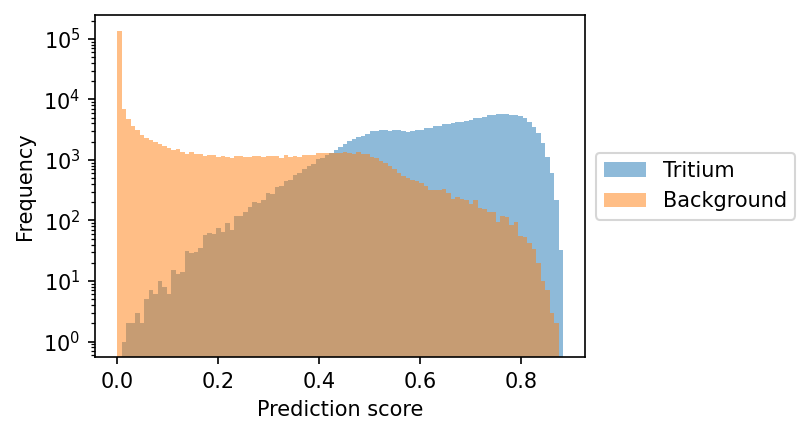

In [73]:
fig, ax  = mlccd_models.plot_scores(ccd_data.y_test, y_pred, threshold_mcc_optimal=None, threshold_mda_optimal=None)

In [74]:
# Count unique primaryKinds for each primaryID
primaryKind_counts = ccd_data.tracks_metadata.groupby('primaryID').primaryKind.nunique()
primaryID_duplicates = primaryKind_counts[primaryKind_counts == 2].index.tolist()


In [75]:
prims_scored_tritium = ccd_data.tracks_metadata.iloc[ccd_data.test_indices].query('primaryKind == 1000010030').primaryID.values
prims_scored_gamma = ccd_data.tracks_metadata.iloc[ccd_data.test_indices].query('primaryKind == 22').primaryID.values

In [76]:
predictions_gamma = model.predict(ccd_data[prims_scored_gamma])
predictions_tritium = model.predict(ccd_data[prims_scored_tritium])

7497/7497 ━━━━━━━━━━━━━━━━━━━━ 5s 640us/step
5987/5987 ━━━━━━━━━━━━━━━━━━━━ 4s 620us/step


In [77]:
# Create a dictionary mapping primaryID to prediction
prediction_dict_tritium = dict(zip(prims_scored_tritium, predictions_tritium))
prediction_dict_gamma = dict(zip(prims_scored_gamma, predictions_gamma))
# Assign predictions to df_tritium_scored
df_tritium_scored = df_tritium[df_tritium.primaryID.isin(prims_scored_tritium)].copy()
df_tritium_scored['prediction'] = df_tritium_scored['primaryID'].map(prediction_dict_tritium)

# Assign predictions to df_gamma_scored
df_gamma_scored = df_gamma[df_gamma.primaryID.isin(prims_scored_gamma)].copy()
df_gamma_scored['prediction'] = df_gamma_scored['primaryID'].map(prediction_dict_gamma)

NameError: name 'mda_threshold' is not defined

/home/emil/miniconda3/envs/mlccd/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/emil/miniconda3/envs/mlccd/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


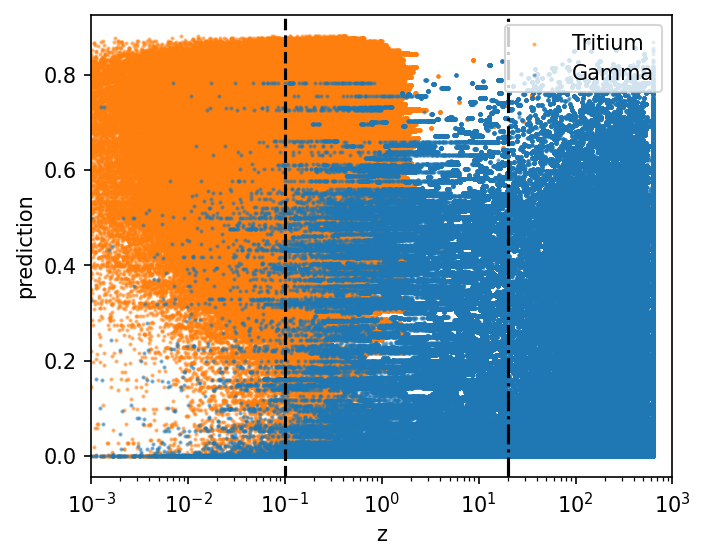

In [78]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=150)
df_tritium_scored.plot(x='z', y='prediction', kind='scatter', alpha=0.5, s=1, ax=ax, label="Tritium", color='C1')
df_gamma_scored.plot(x='z', y='prediction', kind='scatter', alpha=0.5, s=1, ax=ax, label="Gamma", color='C0')
plt.legend()
plt.xscale('log')
plt.xlim(1e-3, 1e3)
# Add vertical line at x=0.1
ax.axvline(x=0.1, color='k', linestyle='--', label='dead layer end')
ax.axvline(x=20, color='k', linestyle='-.', label='fine-step end')
# add horizontal line at y=mda_threshold
ax.axhline(y=mda_threshold, color='r', linestyle='--', label='MDA threshold')
plt.legend(bbox_to_anchor=(1.05, 0.7))


In [82]:
predictions = model.predict(ccd_data.x_test).flatten()
high_threshold = 0.7
low_threshold = 0.3
high_threshold = mda_threshold
low_threshold = mda_threshold
print(f"High threshold: {high_threshold}")
print(f"Low threshold: {low_threshold}")
# Categorize predictions
predictions_categorical = np.zeros_like(predictions, dtype=int)
predictions_categorical[predictions > high_threshold] = 1
predictions_categorical[(predictions >= low_threshold) & (predictions <= high_threshold)] = 2

true_negatives = np.where((predictions_categorical == 0) & (ccd_data.y_test == 0))[0]
false_positives = np.where((predictions_categorical == 1) & (ccd_data.y_test == 0))[0]
false_negatives = np.where((predictions_categorical == 0) & (ccd_data.y_test == 1))[0]
true_positives = np.where((predictions_categorical == 1) & (ccd_data.y_test == 1))[0]
uncertain = np.where(predictions_categorical == 2)[0]
FN_primaryIDs = ccd_data.tracks_metadata.iloc[false_negatives].primaryID.values
TP_primaryIDs = ccd_data.tracks_metadata.iloc[true_positives].primaryID.values
FP_primaryIDs = ccd_data.tracks_metadata.iloc[false_positives].primaryID.values
TN_primaryIDs = ccd_data.tracks_metadata.iloc[true_negatives].primaryID.values

13284/13284 ━━━━━━━━━━━━━━━━━━━━ 9s 658us/step
High threshold: 0.6999305884043375
Low threshold: 0.6999305884043375


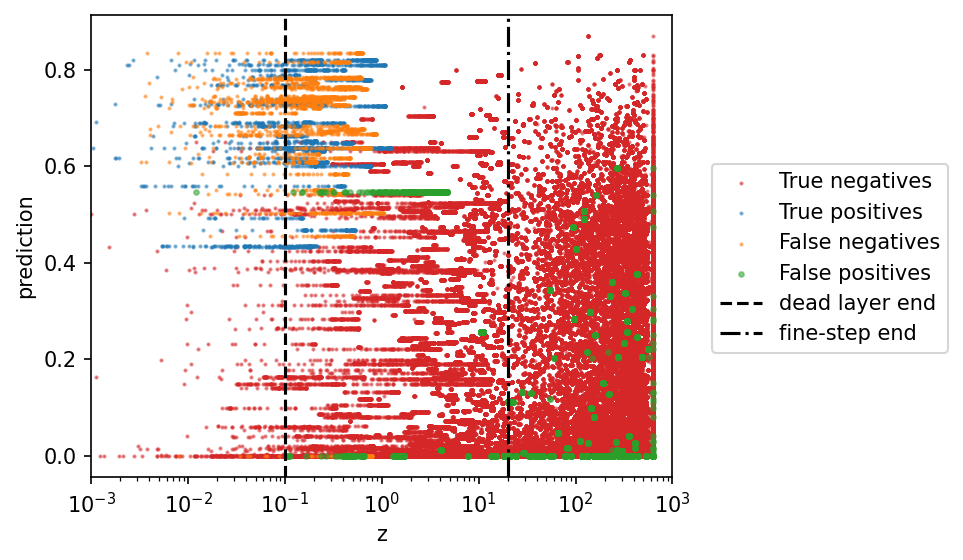

In [83]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=150)
df_gamma_scored.query('primaryID in @TN_primaryIDs').plot(x='z', y='prediction', kind='scatter', alpha=0.5, ax=ax, color='C3', s=1, label="True negatives")
df_tritium_scored.query('primaryID in @TP_primaryIDs').plot(x='z', y='prediction', kind='scatter', alpha=0.5, ax=ax, color='C0', s=1, label="True positives")
df_tritium_scored.query('primaryID in @FN_primaryIDs').plot(x='z', y='prediction', kind='scatter', alpha=0.5, ax=ax, color='C1', s=1, label="False negatives")
df_gamma_scored.query('primaryID in @FP_primaryIDs').plot(x='z', y='prediction', kind='scatter', alpha=0.5, ax=ax, color='C2', s=5, label="False positives")
# plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-3, 1e3)
# Add vertical line at x=0.1
ax.axvline(x=0.1, color='k', linestyle='--', label='dead layer end')
ax.axvline(x=20, color='k', linestyle='-.', label='fine-step end')
plt.legend(bbox_to_anchor=(1.05, 0.7))



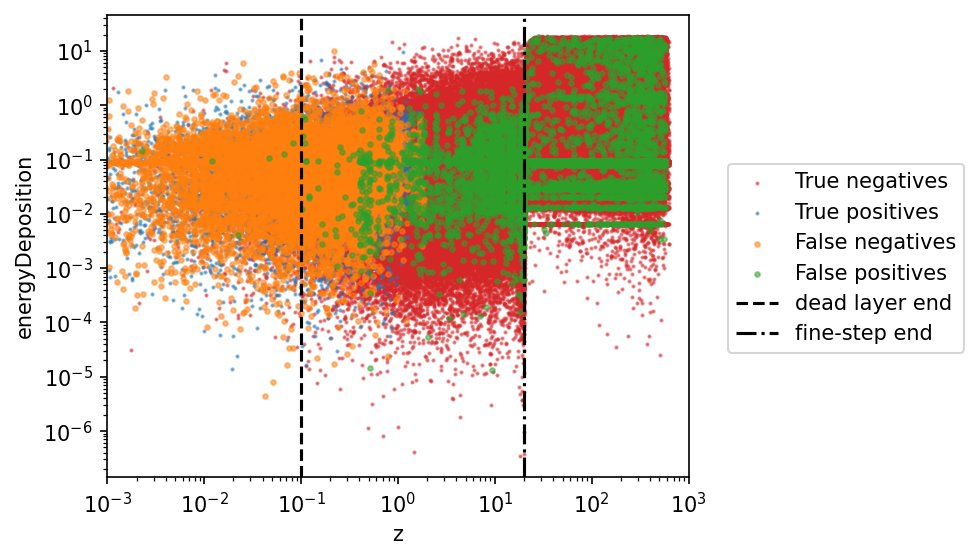

In [84]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=150)
df_gamma.query('primaryID in @TN_primaryIDs').plot(x='z', y='energyDeposition', kind='scatter', alpha=0.5, ax=ax, color='C3', s=1, label="True negatives")
df_tritium.query('primaryID in @TP_primaryIDs').plot(x='z', y='energyDeposition', kind='scatter', alpha=0.5, ax=ax, color='C0', s=1, label="True positives")
df_tritium.query('primaryID in @FN_primaryIDs').plot(x='z', y='energyDeposition', kind='scatter', alpha=0.5, ax=ax, color='C1', s=5, label="False negatives")
df_gamma.query('primaryID in @FP_primaryIDs').plot(x='z', y='energyDeposition', kind='scatter', alpha=0.5, ax=ax, color='C2', s=5, label="False positives")
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-3, 1e3)
# Add vertical line at x=0.1
ax.axvline(x=0.1, color='k', linestyle='--', label='dead layer end')
ax.axvline(x=20, color='k', linestyle='-.', label='fine-step end')
plt.legend(bbox_to_anchor=(1.05, 0.7))



/tmp/ipykernel_1595/1836269907.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  [ax.legend().set_visible(False) for ax in axs]


Text(0.5, 1.0, 'True Positives')

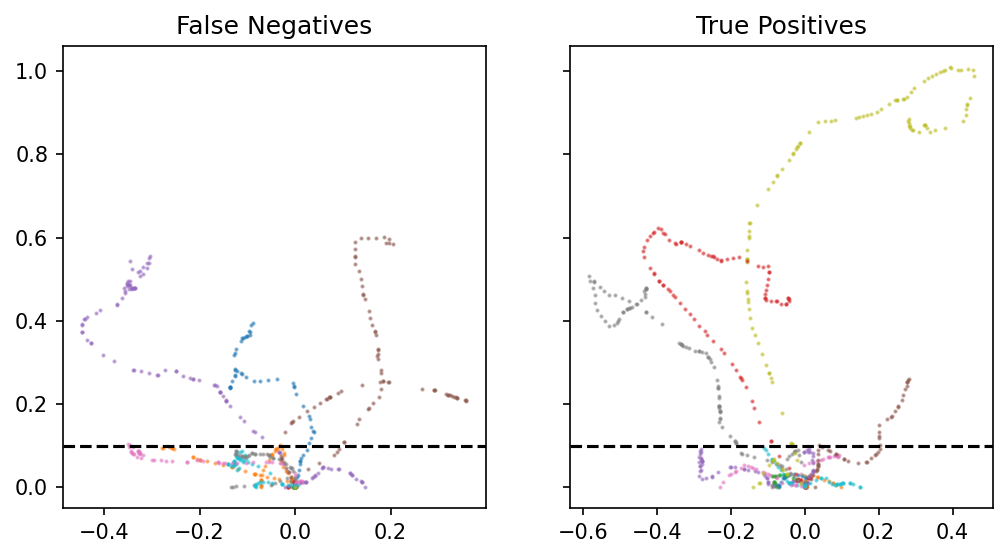

In [85]:
t_FN_prims = df_tritium.query('primaryID in @FN_primaryIDs').primaryID.unique()
t_TP_prims = df_tritium.query('primaryID in @TP_primaryIDs').primaryID.unique()	
fig, axs = plt.subplots(1,2, figsize=(8, 4), dpi=150, sharey=True)
num_to_plot = 20
for prim in t_FN_prims[:num_to_plot]:
    x = df_tritium.query(f'primaryID == {prim}').x.values - df_tritium.query(f'primaryID == {prim}').x.values[0]
    z = df_tritium.query(f'primaryID == {prim}').z.values
    axs[0].plot(x, z, alpha=0.5, ms='2', ls='', marker='.')
for prim in t_TP_prims[:num_to_plot]:
    x = df_tritium.query(f'primaryID == {prim}').x.values - df_tritium.query(f'primaryID == {prim}').x.values[0]
    z = df_tritium.query(f'primaryID == {prim}').z.values
    axs[1].plot(x, z, alpha=0.5, ms='2', ls='', marker='.')
[ax.legend().set_visible(False) for ax in axs]
[ax.axhline(y=0.1, color='k', linestyle='--', label='dead layer end') for ax in axs]
axs[0].set_title('False Negatives')
axs[1].set_title('True Positives')

/tmp/ipykernel_1595/3760850324.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  [ax.legend().set_visible(False) for ax in axs]


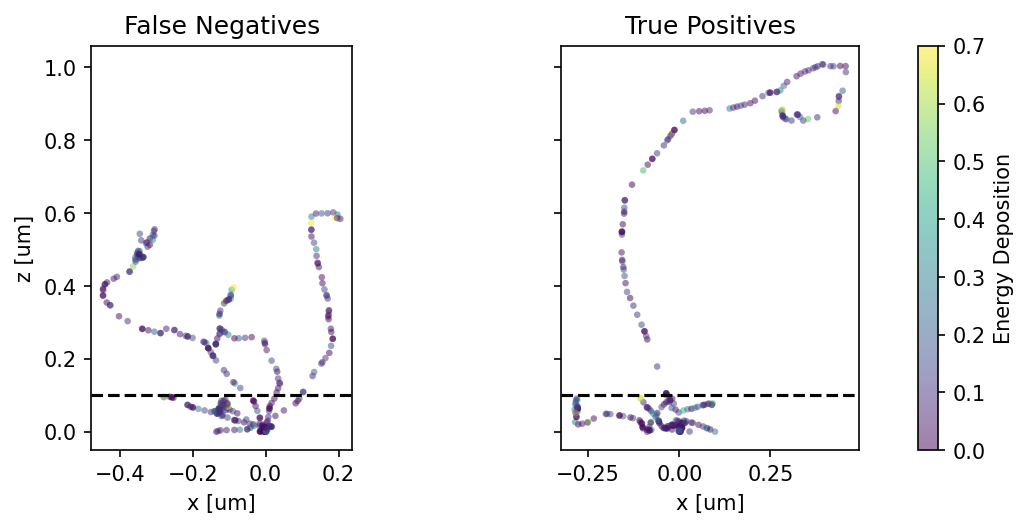

In [86]:
t_FN_prims = df_tritium.query('primaryID in @FN_primaryIDs').primaryID.unique()
t_TP_prims = df_tritium.query('primaryID in @TP_primaryIDs').primaryID.unique()	
fig, axs = plt.subplots(1, 2, figsize=(10, 3.5), dpi=150, sharey=True)
num_to_plot = 30
vmin = 0
vmax = 0.7
# Plot for False Negatives
for prim in t_FN_prims[:num_to_plot]:
    x = df_tritium.query(f'primaryID == {prim}').x.values - df_tritium.query(f'primaryID == {prim}').x.values[0]
    z = df_tritium.query(f'primaryID == {prim}').z.values
    energy_deposition = df_tritium.query(f'primaryID == {prim}')['energyDeposition'].values
    scatter = axs[0].scatter(x, z, c=energy_deposition, alpha=0.5, s=10, cmap='viridis', vmin=vmin, vmax=vmax, linewidths=0)

# Plot for True Positives
for prim in t_TP_prims[:num_to_plot]:
    x = df_tritium.query(f'primaryID == {prim}').x.values - df_tritium.query(f'primaryID == {prim}').x.values[0]
    z = df_tritium.query(f'primaryID == {prim}').z.values
    energy_deposition = df_tritium.query(f'primaryID == {prim}')['energyDeposition'].values
    scatter = axs[1].scatter(x, z, c=energy_deposition, alpha=0.5, s=10, cmap='viridis', vmin=vmin, vmax=vmax, linewidths=0)

# Remove legends and add horizontal lines
[ax.legend().set_visible(False) for ax in axs]
[ax.axhline(y=0.1, color='k', linestyle='--', label='dead layer end') for ax in axs]

# Set titles for the subplots
axs[0].set_title('False Negatives')
axs[1].set_title('True Positives')
[ax.set_aspect('equal') for ax in axs]
axs[0].set_xlabel('x [um]')
axs[1].set_xlabel('x [um]')
axs[0].set_ylabel('z [um]')

# Add colorbar for energy deposition
fig.colorbar(scatter, ax=axs, orientation='vertical', label='Energy Deposition')

/tmp/ipykernel_1595/4068468844.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  [ax.legend().set_visible(False) for ax in axs]


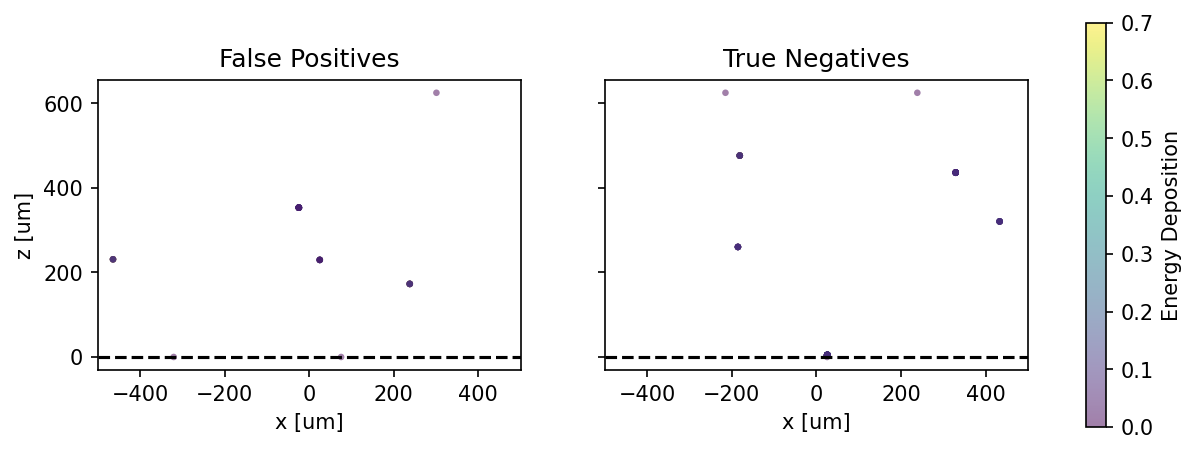

In [138]:
t_FP_prims = df_gamma.query('primaryID in @FP_primaryIDs').primaryID.unique()
t_TN_prims = df_gamma.query('primaryID in @TN_primaryIDs').primaryID.unique()	
fig, axs = plt.subplots(1, 2, figsize=(10, 3.5), dpi=150, sharey=True)
num_to_plot = 10
vmin = 0
vmax = 0.7
# Plot for False Positives  
for prim in t_FP_prims[:num_to_plot]:
    x = df_gamma.query(f'primaryID == {prim}').x.values# - df_gamma.query(f'primaryID == {prim}').x.values[0]
    z = df_gamma.query(f'primaryID == {prim}').z.values
    energy_deposition = df_gamma.query(f'primaryID == {prim}')['energyDeposition'].values
    scatter = axs[0].scatter(x, z, c=energy_deposition, alpha=0.5, s=10, cmap='viridis', vmin=vmin, vmax=vmax, linewidths=0)

# Plot for True Negatives
for prim in t_TN_prims[:num_to_plot]:
    x = df_gamma.query(f'primaryID == {prim}').x.values# - df_gamma.query(f'primaryID == {prim}').x.values[0]
    z = df_gamma.query(f'primaryID == {prim}').z.values
    energy_deposition = df_gamma.query(f'primaryID == {prim}')['energyDeposition'].values
    scatter = axs[1].scatter(x, z, c=energy_deposition, alpha=0.5, s=10, cmap='viridis', vmin=vmin, vmax=vmax, linewidths=0)

# Remove legends and add horizontal lines
[ax.legend().set_visible(False) for ax in axs]
[ax.axhline(y=0.1, color='k', linestyle='--', label='dead layer end') for ax in axs]

# Set titles for the subplots
axs[0].set_title('False Positives')
axs[1].set_title('True Negatives')
[ax.set_aspect('equal') for ax in axs]
axs[0].set_xlabel('x [um]')
axs[1].set_xlabel('x [um]')
axs[0].set_ylabel('z [um]')
[ax.set_xlim(-500, 500) for ax in axs]

# Add colorbar for energy deposition
fig.colorbar(scatter, ax=axs, orientation='vertical', label='Energy Deposition')

In [99]:
(df_gamma.query(f'primaryID == {prim}').x + 100).values

array([150.82372, 453.89062, 150.82143, 150.80952, 150.81493, 150.82033],
      dtype=float32)

<Axes: >

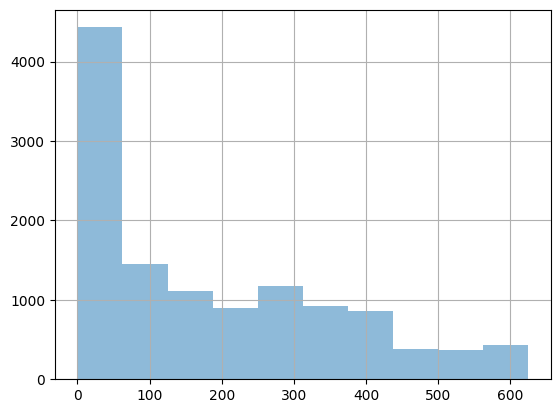

In [112]:
df_gamma.query('primaryID in @FP_primaryIDs').z.hist(alpha=0.5)
# df_gamma.query('primaryID in @TN_primaryIDs').z.hist(alpha=0.5)


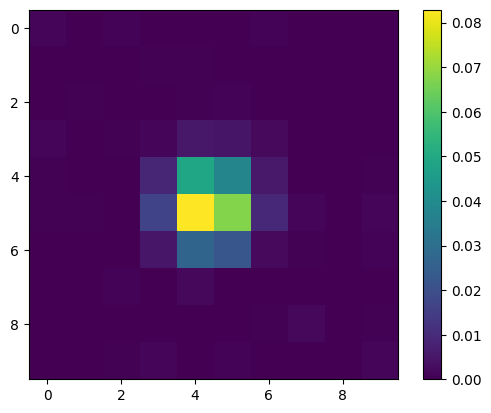

In [125]:
plt.imshow(ccd_data[g_FP_prims[0]])
plt.colorbar()

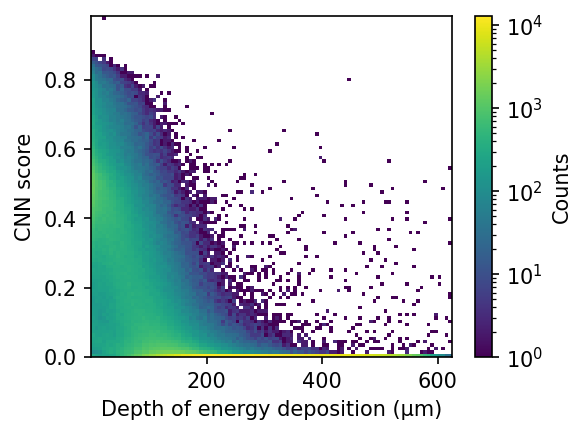

In [133]:
fig, ax = plt.subplots(figsize=(4,3), dpi=150)

# Create 2D histogram
hist = ax.hist2d(
    ccd_data.tracks_metadata.query('primaryKind == 22').zFirstUm.values,
    ccd_data.tracks_metadata.query('primaryKind == 22').prediction_cnn.values,
    # ccd_data.tracks_metadata.query('primaryKind == 22').prediction_autoencoder.values,
    # ccd_data.tracks_metadata.query('primaryKind == 22').classicalDiscriminatorS.values,
    bins=100,
    norm=LogNorm(),
    cmap='viridis'
)

# Add labels and colorbar
ax.set_xlabel('Depth of energy deposition (µm)')
ax.set_ylabel('CNN score')
plt.colorbar(hist[3], ax=ax, label='Counts')

plt.tight_layout()

In [120]:
df_gamma.query(f'primaryID == {g_FP_prims[0]}')

detectorID  energyDeposition            x            y             z  \
12314           2          0.026700  1593.247314  1448.859619  1.487171e+02   
12315           1          0.000000  1644.549927  1625.302246  1.734723e-15   
12316           2          0.095600  1593.247437  1448.859375  1.487171e+02   
12317           2          0.029250  1593.247437  1448.859619  1.487171e+02   
12318           2          0.471241  1593.283203  1448.857422  1.487661e+02   
12319           2          5.635787  1593.398804  1448.849609  1.489279e+02   
12320           2          0.087830  1593.395020  1448.849976  1.489221e+02   
12321           2          0.087830  1593.372559  1448.851440  1.488916e+02   
12322           2          0.087830  1593.360596  1448.852051  1.488743e+02   
12323           2          0.087830  1593.345337  1448.853027  1.488534e+02   
12324           2          0.088490  1593.383667  1448.850830  1.489068e+02   
12325           2          0.095600  1593.369019  1448.851807  1.488859e+02   
12326           2          0.080720  1593.338379  1448.853760  1.488435e+02   
12327           2          0.037020  1593.338501  1448.853760  1.488436e+02   
12328           2          0.088490  1593.301270  1448.856323  1.487911e+02   
12329           2          0.036360  1593.301147  1448.856079  1.487911e+02   

       primaryID  primaryKind  energyPrimary  stepKind  energyPreStep  \
12314      30796           22          100.0        22     100.000000   
12315      30796           22          100.0        22      92.963417   
12316      30796           22          100.0        11       0.095600   
12317      30796           22          100.0        11       0.029250   
12318      30796           22          100.0        11       6.885029   
12319      30796           22          100.0        11       6.413788   
12320      30796           22          100.0        11       0.087830   
12321      30796           22          100.0        11       0.087830   
12322      30796           22          100.0        11       0.087830   
12323      30796           22          100.0        11       0.087830   
12324      30796           22          100.0        11       0.088490   
12325      30796           22          100.0        11       0.095600   
12326      30796           22          100.0        11       0.080720   
12327      30796           22          100.0        11       0.037020   
12328      30796           22          100.0        11       0.088490   
12329      30796           22          100.0        11       0.036360   

      creatorProcess  particleID  parentID  energyEscape  
12314        primary           1         0      0.000000  
12315        primary           1         0     92.963417  
12316          compt           2         1      0.000000  
12317          compt           3         1      0.000000  
12318          compt           4         1      0.000000  
12319          compt           5         1      0.000000  
12320          eIoni           6         2      0.000000  
12321          eIoni           7         2      0.000000  
12322          eIoni           8         2      0.000000  
12323          eIoni           9         2      0.000000  
12324          eIoni          10         2      0.000000  
12325          eIoni          11         2      0.000000  
12326          eIoni          12         2      0.000000  
12327          eIoni          13         2      0.000000  
12328          eIoni          14         2      0.000000  
12329          eIoni          15         2      0.000000

/tmp/ipykernel_1595/709702136.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  [ax.legend().set_visible(False) for ax in axs]


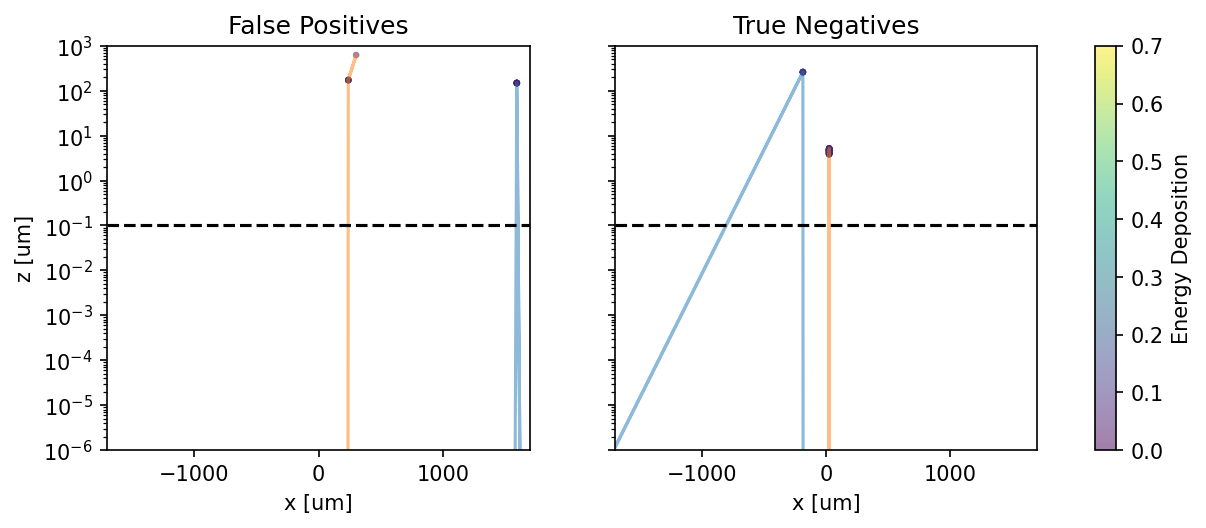

In [122]:
g_FP_prims = df_gamma.query('primaryID in @FP_primaryIDs & primaryKind == 22').primaryID.unique()
g_TN_prims = df_gamma.query('primaryID in @TN_primaryIDs & primaryKind == 22').primaryID.unique()	
fig, axs = plt.subplots(1, 2, figsize=(10, 3.5), dpi=150, sharey=True)
num_to_plot = 2
vmin = 0
vmax = 0.7
# Plot for False Positives
for prim in g_FP_prims[:num_to_plot]:
    rand_shift = np.random.random()*0
    x = df_gamma.query(f'primaryID == {prim}').x.values + rand_shift# - df_gamma.query(f'primaryID == {prim}').x.values[0]
    z = df_gamma.query(f'primaryID == {prim}').z.values
    energy_deposition = df_gamma.query(f'primaryID == {prim}')['energyDeposition'].values
    scatter = axs[0].scatter(x, z, c=energy_deposition, alpha=0.5, s=10, cmap='viridis', vmin=vmin, vmax=vmax, linewidths=0)
    axs[0].plot(np.concatenate([[rand_shift], x]), np.concatenate([[0], z]), alpha=0.5)


# Plot for True Negatives   
for prim in g_TN_prims[:num_to_plot]:
    x = df_gamma.query(f'primaryID == {prim}').x.values# - df_gamma.query(f'primaryID == {prim}').x.values[0]
    z = df_gamma.query(f'primaryID == {prim}').z.values
    energy_deposition = df_gamma.query(f'primaryID == {prim}')['energyDeposition'].values
    scatter = axs[1].scatter(x, z, c=energy_deposition, alpha=0.5, s=10, cmap='viridis', vmin=vmin, vmax=vmax, linewidths=0)
    axs[1].plot(np.concatenate([[0], x]), np.concatenate([[0], z]), alpha=0.5)

# Remove legends and add horizontal lines
[ax.legend().set_visible(False) for ax in axs]
[ax.axhline(y=0.1, color='k', linestyle='--', label='dead layer end') for ax in axs]

# Set titles for the subplots
axs[0].set_title('False Positives')
axs[1].set_title('True Negatives')
# [ax.set_aspect('equal') for ax in axs]
axs[0].set_xlabel('x [um]')
axs[1].set_xlabel('x [um]')
axs[0].set_ylabel('z [um]')
[ax.set_xlim(-1700, 1700) for ax in axs]
[ax.set_yscale('log') for ax in axs]
[ax.set_ylim(1e-6, 1e3) for ax in axs]

# Add colorbar for energy deposition
fig.colorbar(scatter, ax=axs, orientation='vertical', label='Energy Deposition')

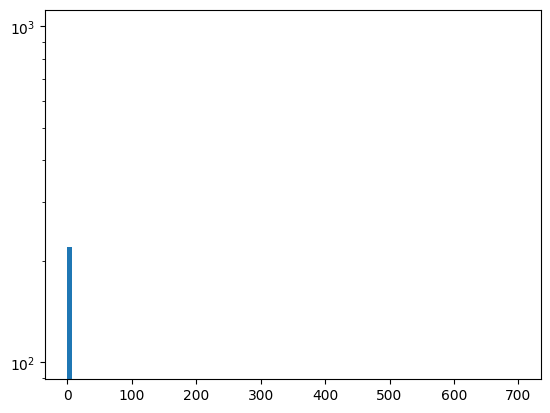

In [34]:
bins = np.linspace(0, 700, 100)
df_tritium.query('primaryID in @FN_primaryIDs').groupby('primaryID').z.max().hist(bins=bins, label="False negatives", grid=False)
plt.yscale('log')


### Find cluster true/false

NameError: name 'sns' is not defined

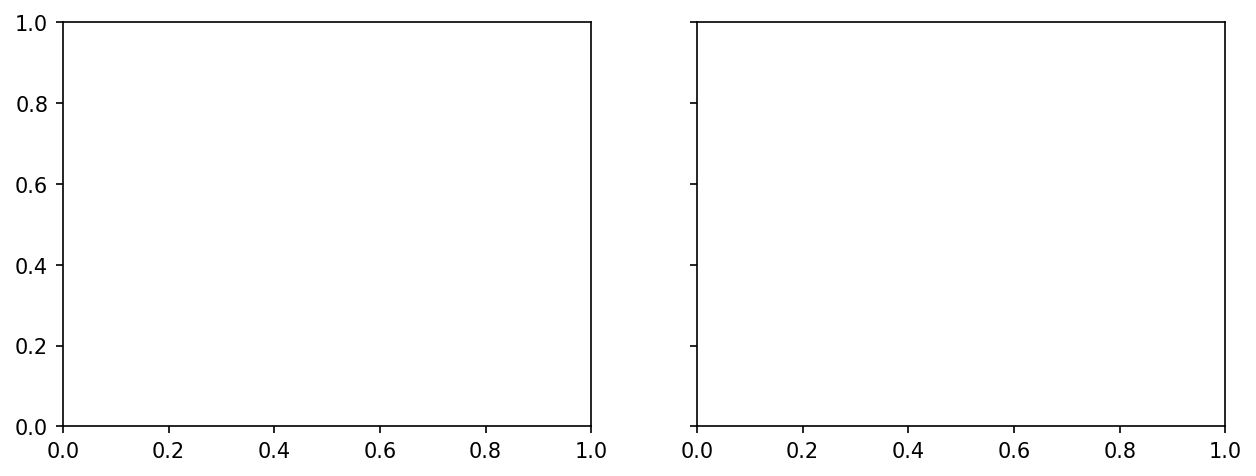

In [113]:
g_FP_prims = df_gamma.query('primaryID in @FP_primaryIDs').primaryID.unique()
g_TN_prims = df_gamma.query('primaryID in @TN_primaryIDs').primaryID.unique()	
fig, axs = plt.subplots(1, 2, figsize=(10, 3.5), dpi=150, sharey=True)

# Function to create a 2D histogram with average energy deposition
def plot_average_energy(ax, primary_ids, label):
    all_data = []
    for prim in primary_ids:
        x = df_gamma.query(f'primaryID == {prim}').x.values
        z = df_gamma.query(f'primaryID == {prim}').z.values
        energy_deposition = df_gamma.query(f'primaryID == {prim}')['energyDeposition'].values
        all_data.append(pd.DataFrame({'x': x, 'z': z, 'energy_deposition': energy_deposition}))

    combined_data = pd.concat(all_data)
    # Group by x and z to calculate the average energy deposition
    avg_energy = combined_data.groupby(['x', 'z'], as_index=False).mean()

    # Create the 2D histogram with specified bins
    bins_x = np.linspace(combined_data.x.min(), combined_data.x.max(), 50)  # Adjust the number of bins as needed
    bins_y = np.linspace(combined_data.z.min(), combined_data.z.max(), 50)  # Adjust the number of bins as needed
    sns.histplot(data=avg_energy, x='x', y='z', 
                 weights='energy_deposition', 
                 ax=ax, bins=[bins_x, bins_y], cmap='viridis', 
                 cbar=True, stat='density', fill=True)

    ax.set_title(label)

# Plot for False Positives
plot_average_energy(axs[0], g_FP_prims, 'False Positives')

# Plot for True Negatives   
plot_average_energy(axs[1], g_TN_prims, 'True Negatives')

# Set common labels
axs[0].set_xlabel('x [um]')
axs[1].set_xlabel('x [um]')
axs[0].set_ylabel('z [um]')
[ax.set_xlim(-1400, 1400) for ax in axs]

In [39]:
look = df_tritium.query('primaryID in @FN_primaryIDs & primaryKind == 1000010030')

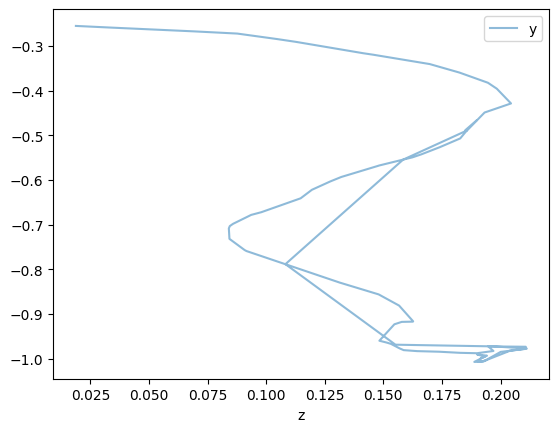

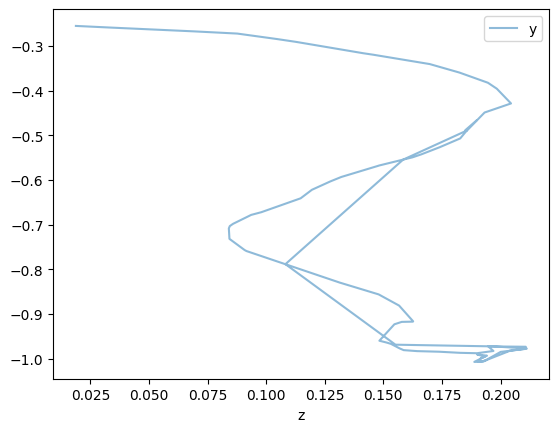

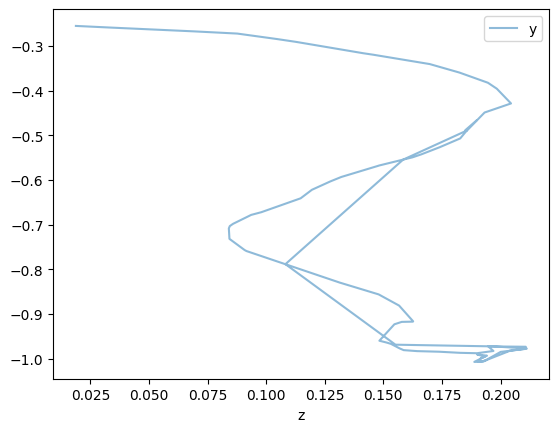

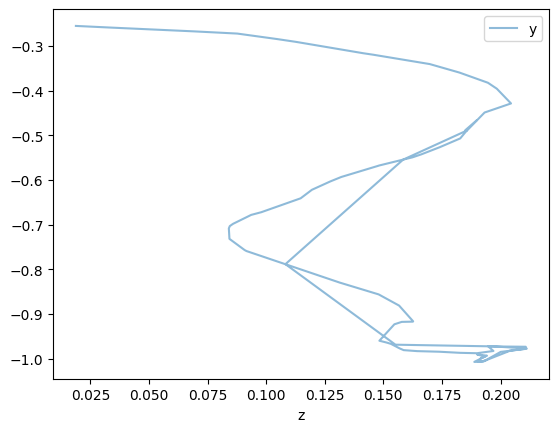

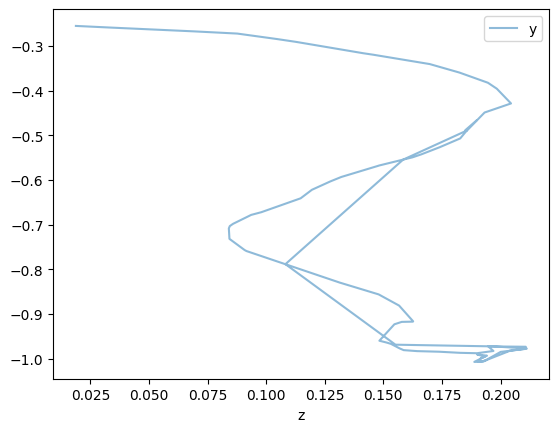

In [40]:
FN_trit_prims = df_tritium.query('primaryID in @FN_primaryIDs & primaryKind == 1000010030').primaryID.values
for prim in FN_trit_prims[:5]:
    df_tritium.query(f'primaryID == {prim}').plot(x='z', y='y', alpha=0.5, kind='line', ms='2')



In [41]:
ccd_data.tracks_metadata.query('primaryID == 63').energyDeadLayerSumKeV

Series([], Name: energyDeadLayerSumKeV, dtype: float32)

In [42]:
df_tritium

detectorID  energyDeposition         x          y         z  \
0                 1          0.233613  6.927932  18.006439  0.002364   
1                 1          0.036990  6.938752  18.022779  0.006356   
2                 1          0.005220  6.951589  18.042349  0.011126   
3                 1          0.001435  6.952940  18.044796  0.011802   
4                 1          0.013669  6.962514  18.060913  0.018771   
...             ...               ...       ...        ...       ...   
9999995           1          0.094940 -0.477212   1.811296  0.292034   
9999996           1          0.094940 -0.500783   2.005142  0.336601   
9999997           1          0.029940 -0.500427   2.005175  0.336440   
9999998           1          0.087830 -0.489641   2.096464  0.326787   
9999999           1          0.094940 -0.571462   2.214018  0.223975   

         primaryID  primaryKind  energyPrimary  stepKind  energyPreStep  \
0                2   1000010030            0.0        11       5.779344   
1                2   1000010030            0.0        11       5.545731   
2                2   1000010030            0.0        11       5.413831   
3                2   1000010030            0.0        11       5.408611   
4                2   1000010030            0.0        11       5.407176   
...            ...          ...            ...       ...            ...   
9999995     613972   1000010030            0.0        11       0.094940   
9999996     613972   1000010030            0.0        11       0.094940   
9999997     613972   1000010030            0.0        11       0.029940   
9999998     613972   1000010030            0.0        11       0.087830   
9999999     613972   1000010030            0.0        11       0.094940   

        creatorProcess  particleID  parentID  energyEscape  
0           Radioactiv           4         1           0.0  
1           Radioactiv           4         1           0.0  
2           Radioactiv           4         1           0.0  
3           Radioactiv           4         1           0.0  
4           Radioactiv           4         1           0.0  
...                ...         ...       ...           ...  
9999995          eIoni          16         4           0.0  
9999996          eIoni          17         4           0.0  
9999997          eIoni          18         4           0.0  
9999998          eIoni          19         4           0.0  
9999999          eIoni          20         4           0.0  

[9849553 rows x 14 columns]

# Read/Write #TODO change this now that there's no "trainer"

In [43]:
model.save(f"{config['model_name']}.keras")


In [15]:
model.save("cnn_sim.keras")